In [923]:
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

In [924]:


trainFile = "D:/GitHub/Datasets/books.csv"

pwd = os.getcwd()
os.chdir(os.path.dirname(trainFile))
trainData = pd.read_csv(os.path.basename(trainFile),error_bad_lines=False)
os.chdir(pwd)

In [925]:
df =trainData

# Business Understanding:
## The Good Reads dataset provides a list of books from the website with their respective ratings.
#### Questions to pose for hypothesis are:
* Does the reoccurance of a book through different publications bias the rating?
* Does the ratings count and text review counts affect the rating 
* Does the popularity of the author affect the rating?
* Does the number of pages of a book affect its rating? 

# Data Understanding
### Lets get some stats on our data to have a better undertsanding of the information

#### First lets check the data types we have in the dataframe:

In [926]:
df.dtypes

bookID                  int64
title                  object
authors                object
average_rating         object
isbn                   object
isbn13                 object
language_code          object
# num_pages            object
ratings_count           int64
text_reviews_count      int64
Unnamed: 10           float64
dtype: object

oops, it seems like average rating & number of pages are not in the right format. After attempting to convert average_rating to float I received an error that shows that some entries are corrupt. i.e with names instead of numbers. Hence the conversion failed.

In [927]:
#converting average rating and number of pages to numeric

df['average_rating'] = pd.to_numeric(df['average_rating'],errors='coerce')
df['# num_pages'] = pd.to_numeric(df['# num_pages'],errors='coerce')

In [928]:
df.describe()

,bookID,average_rating,# num_pages,ratings_count,text_reviews_count,Unnamed: 10
count,13719.000000,13714.000000,13714.000000,1.371900e+04,13719.000000,5.000000
mean,22160.579270,3.930620,342.402727,1.775903e+04,533.606385,6.200000
std,13699.603351,0.357893,252.650165,1.129371e+05,2528.600316,6.418723
min,1.000000,0.000000,0.000000,0.000000e+00,0.000000,0.000000
25%,10621.000000,3.770000,196.000000,8.300000e+01,7.000000,4.000000
50%,21322.000000,3.960000,301.000000,6.300000e+02,40.000000,4.000000
75%,33322.000000,4.130000,421.000000,4.737000e+03,222.000000,6.000000
max,47709.000000,5.000000,6576.000000,5.629932e+06,93619.000000,17.000000


In [929]:
#explore if any missing values or nans

no_nulls = set(df.columns[df.isnull().mean()>0])
no_nulls

{'# num_pages', 'Unnamed: 10', 'average_rating'}

In [930]:
df=df.drop(['Unnamed: 10'], axis=1)

## We now have a dataset with no NaNs

In [931]:
#verifying if Average ratings has any missing vlaues placed as 0

missing_data=df.loc[df['average_rating'] == 0]

missing_data.shape[0]


34

In [932]:
#dropping records with missing ratings 

indexNames = df[ df['average_rating'] == 0 ].index
df.drop(indexNames , inplace=True)

## Now that we have a cleaner dataset, time to continue exploring the data

In [933]:
#Creating a function to display the most occurances of an item 

#Taking the first 20:

def rank_count(df,value,pivot):
    '''
    Inputs:
    df = input dataframe 
    Value= Value to be counted
    Pivot= Y label to be viewed
    
    Outputs:
    Visual of the number of times Value has been counted in the dataframe and displaying the top 20 
    
    
    '''
    sns.set_context('notebook')
    plt.figure(figsize=(10,7.5))
    books = df[value].value_counts()[:20]
    sns.barplot(x = books  , y = books.index, palette='Spectral')
    plt.title("Most Occurring "+ value)
    plt.xlabel("Number of occurances")
    plt.ylabel(pivot)
    plt.show()

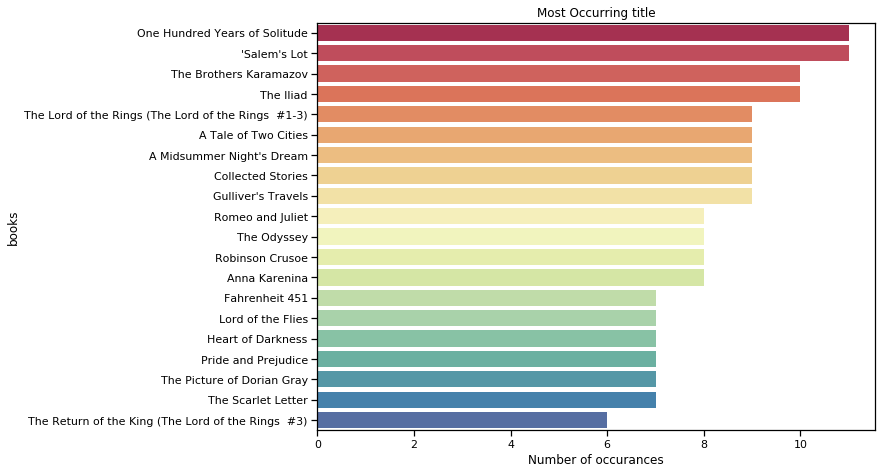

In [934]:
rank_count(df,'title','books')

#### Lets check the average rating of the top 20 most published books

In [939]:
books = df[['title']]
books=books['title'].value_counts()[0:20]

In [940]:

new_df = pd.DataFrame(books)
new_df.reset_index(level=0, inplace=True)
new_df.columns= ['title','title_count']
new_df['average_rating']=0.0

In [941]:
counter=0
for title in new_df['title']:
    new_df['average_rating'][counter]=df[df['title']==title]['average_rating'].mean()
    counter=counter+1


D:\Conda\lib\site-packages\ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


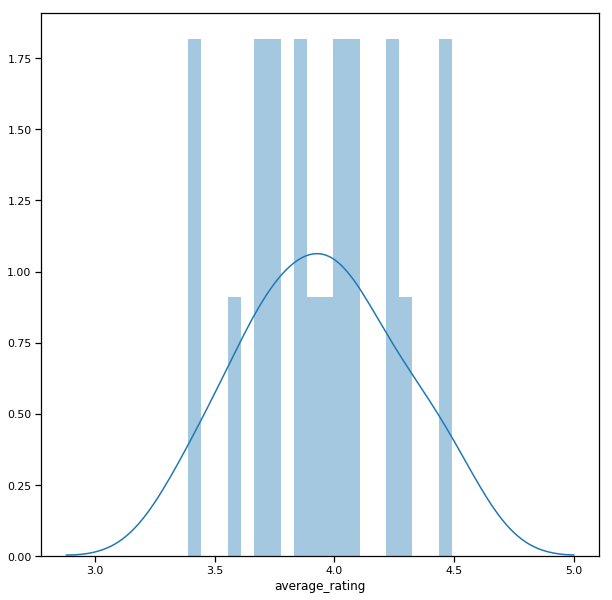

In [942]:
plt.figure(figsize=(10,10))
rating= new_df.average_rating.astype(float)
sns.distplot(rating, bins=20)

#### It seems that the average rating of the top 20 books lies within the 3.5-4.5 range and peaking at 3.9 

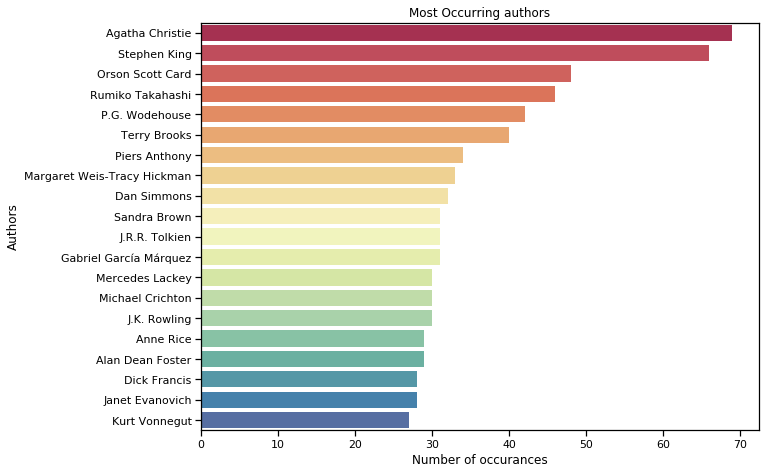

In [943]:
#checking the authors with the highest number of books written
rank_count(df,'authors','Authors')

### With Agatha Christie at number one with 68 books, we have a clear ranking of the authors based on volume of books written. No surprise there as Hercule Poirot is a favorite among many :)

In [944]:
#Checking Data types to ensure correct types relevant to the column data
df.dtypes

bookID                  int64
title                  object
authors                object
average_rating        float64
isbn                   object
isbn13                 object
language_code          object
# num_pages           float64
ratings_count           int64
text_reviews_count      int64
dtype: object

From the above exploration, it seems that we sstill have some cleaning to do. 
* A) there are a few records with high ratings (5) but very low ratings count which is rationally not a real representation of the rating of the books so those need to be dropped. 
* B) many records with 0 rating and 0 ratings count wich would bias our data to a lower count

In [945]:
df.ratings_count.describe()

count    1.368500e+04
mean     1.780315e+04
std      1.130739e+05
min      0.000000e+00
25%      8.400000e+01
50%      6.360000e+02
75%      4.752000e+03
max      5.629932e+06
Name: ratings_count, dtype: float64

In [946]:
#removing books with ratings count less than 10 to ensure books with only enough ratings count are kept to avoid fan bias


indexNames = df[ df['ratings_count'] < 10 ].index
df.drop(indexNames , inplace=True)

indexNames = df[ df['average_rating'] == 0 ].index
df.drop(indexNames , inplace=True)

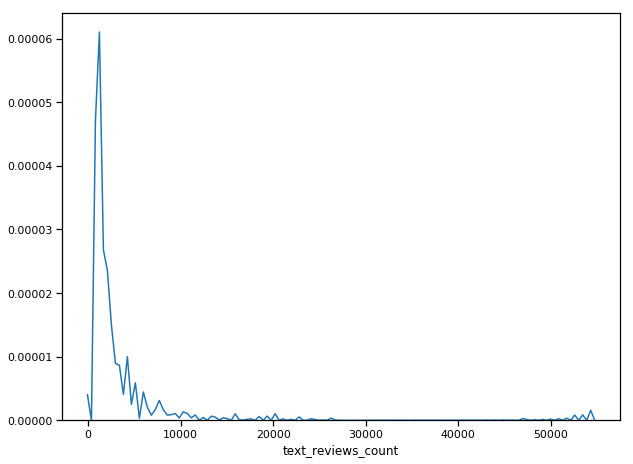

In [947]:
sns.set_context('notebook')
plt.figure(figsize=(10,7.5))
books = df.groupby(['authors']).mean()
ratings_sorted=books.sort_values(by=['average_rating'],ascending=False)
sns.distplot(ratings_sorted['text_reviews_count'], bins=5, hist=False);

In [948]:
#cleaning up some nans found due to dropping records with no ratings

no_nulls = set(df.columns[df.isnull().mean()>0])
no_nulls

{'# num_pages', 'average_rating'}

In [949]:
df=df.dropna()

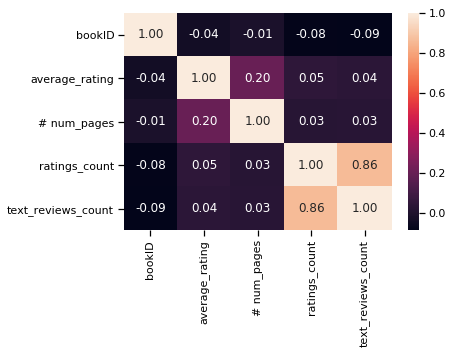

In [950]:
#checking the correlation of features in the current dataframe

sns.heatmap(df.corr(), annot=True, fmt=".2f");

### From the above analysis, we can see that there is a correlation between the number of pages and the average rating. Further more, there is a a strong correlation between the ratings count and the text reviews count. 

In [889]:
def scatt_plot(df,x_label,y_label,color):
    '''
    Inputs:
    df = Dataframe passed that we would like to visualize features of
    x_label = The first feature we want to visualize against
    y_label = The second feature we want to visualize against
    Color = Color of the visual scatter plot we want to display
    
    Outputs:
    Scatter plot visual of the two features x_label and y_label 
    
    '''
    plt.figure(figsize=(15,10))
    sns.set_context('paper')
    ax = sns.jointplot(x=x_label, y=y_label, data =df, color = color)
    ax.set_axis_labels(x_label, y_label)

<Figure size 1080x720 with 0 Axes>

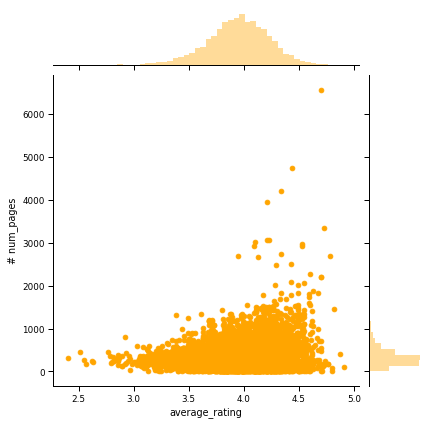

In [951]:
scatt_plot(df,"average_rating","# num_pages",'orange')

### There seems to be quite a few outliers above the 1300 pages mark, so lets strip those first and repeat.

<Figure size 1080x720 with 0 Axes>

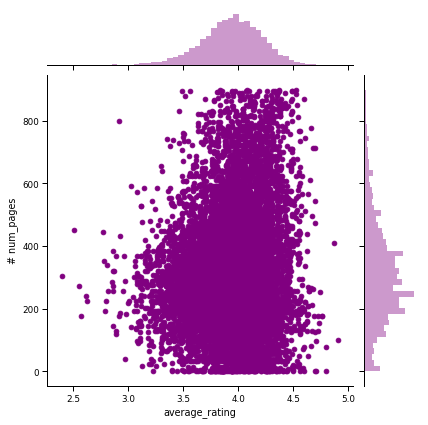

In [953]:
pages_df=df[df['# num_pages']<900]
scatt_plot(pages_df,'average_rating','# num_pages',"purple")

D:\Conda\lib\site-packages\ipykernel_launcher.py:1: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  """Entry point for launching an IPython kernel.


<Figure size 1080x720 with 0 Axes>

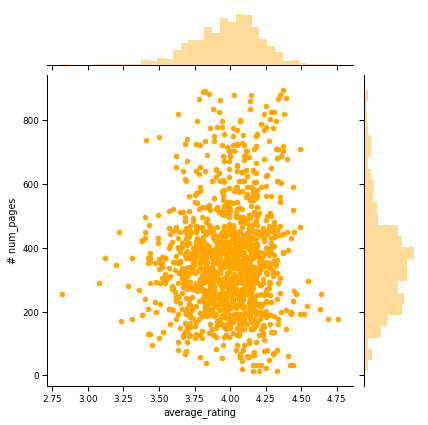

In [954]:
sub_df = pages_df[(ranked_df.ratings_count >=20000) & (ranked_df.ratings_count < 200000)]
scatt_plot(sub_df,'average_rating','# num_pages',"orange")

### From the above graph we can see that the correlation between number of pages and the average rating is within the 200-400 page range. Which infers that people prefer shorter books than large daunting ones.

In [955]:
#Creating a column to hold the number of books published by the author
ranked_df=df
ranked_df['authors_rank']=0

In [956]:
#Getting the count of books published per author 
Authors_list=ranked_df['authors'].value_counts()

In [957]:
#Looking up values from the Authors list series and inputting it in the authors rank column that corresponds to the right author
for i in range(len(ranked_df)):
    ranked_df.iloc[i,10]=Authors_list[ranked_df.iloc[i,2]]

<Figure size 1080x720 with 0 Axes>

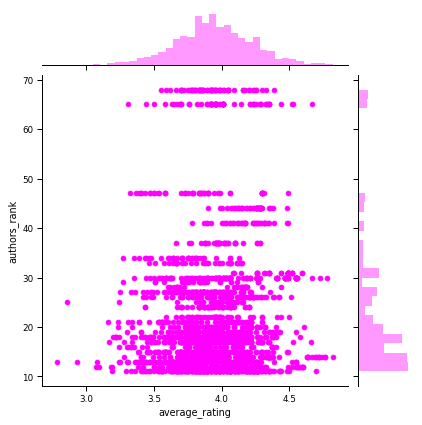

In [958]:

#displaying the average rating of books by authors who have more than 10 books published
published_df=ranked_df[ranked_df['authors_rank']>10]
scatt_plot(published_df,"average_rating",'authors_rank','magenta')

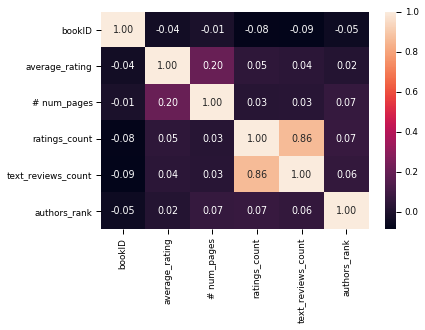

In [857]:
#checking the correlation of features after adding author's rank

sns.heatmap(ranked_df.corr(), annot=True, fmt=".2f");

### How about the number of times each book has been published? Would adding this feature affect the other features? 

In [858]:
#Adding the number of times a book has been published as a column in our dataset 
ranked_df['num_times_published']=0
Book_list=ranked_df['title'].value_counts()

In [859]:
#Looping through the dataset and adding the number of times a book has been published
for i in range(len(ranked_df)):
    ranked_df.iloc[i,11]=Book_list[ranked_df.iloc[i,1]]

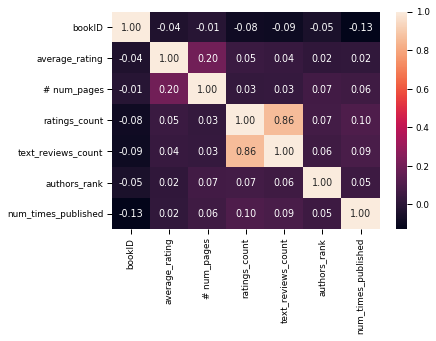

In [860]:
# checking the correlation matric now that we add the new column
sns.heatmap(ranked_df.corr(), annot=True, fmt=".2f");

# Data Modeling:
### Predicting the Average Rating based on the number of pages, the ratings count and the text reviews count:

In [861]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error



# Creating a function for reusability

def ratingsPred(df, responsecol):
    '''
    Inputs:
    df = the dataframe to be processed with all columns 
    responsecol = the column to be predicted
    
    Outputs:
    rsquare_score of the prediciton
    
    
    '''
    # splitting the dataset into the features and target column:
    y = df[responsecol]
    X = df.drop(responsecol, axis=1)

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = .30, random_state=42)

    # instantiating the model
    lm_model = LinearRegression(normalize=True)
    


    #Fit
    lm_model.fit(X_train, y_train)
   

    # predict values
    y_preds_lm=lm_model.predict(X_test)
   
    


    #Rsquared and y_test
    rsquared_score_lm = r2_score(y_test, y_preds_lm)
    length_y_test = len(y_test)
    
    #displaying the average rating of books by authors who have more than 10 books published
    plt.figure(figsize=(15,10))
    sns.set_context('paper')
    published_df=ranked_df[ranked_df['authors_rank']>10]
    ax = sns.jointplot(x=y_preds_lm, y=y_test, color = 'crimson')
    ax.set_axis_labels("Predicted Ratings", "Real Ratings")

    return "The r-squared score for your Linear Regression model was {} on {} values.  ".format(rsquared_score_lm, length_y_test)


'The r-squared score for your Linear Regression model was 0.04811469248733713 on 3820 values.  '

<Figure size 1080x720 with 0 Axes>

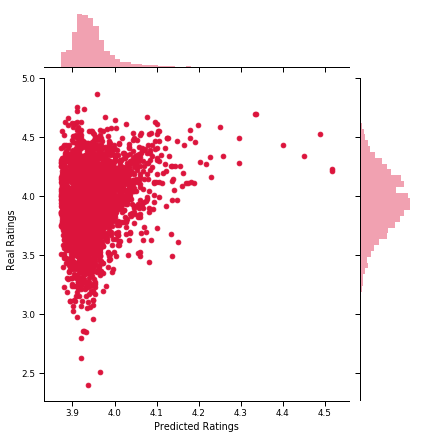

In [862]:

responsecol = 'average_rating'
subdf = ranked_df[['average_rating','# num_pages','ratings_count','text_reviews_count','authors_rank','num_times_published']]
ratingsPred(subdf,responsecol)

## Now lets see if we can improve the model by adding any of the categorical columns we have such as language code

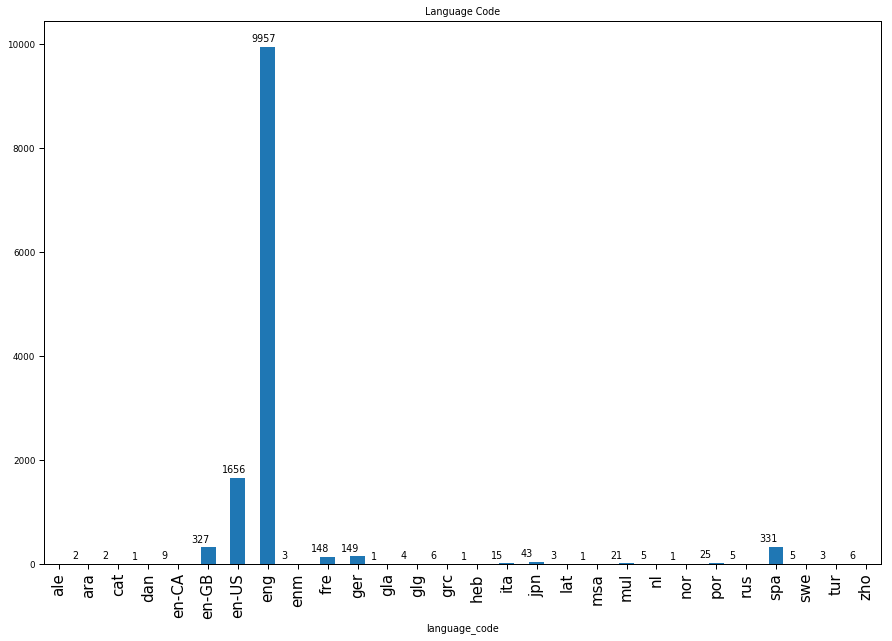

In [863]:
sns.set_context('paper')
plt.figure(figsize=(15,10))
ax = df.groupby('language_code')['title'].count().plot.bar()
plt.title('Language Code')
plt.xticks(fontsize = 15)
for p in ax.patches:
    ax.annotate(str(p.get_height()), (p.get_x()-0.3, p.get_height()+100))

### From the above graph we can see that the majority of books are in english, hence for the sake of the experiment we will drop all the other language columns and one-hot encode the language column to add more info to our prediction done later.

In [864]:
ranked_df = pd.concat([ranked_df.drop('language_code', axis=1), pd.get_dummies(df['language_code'], prefix='language_code', prefix_sep='_', drop_first=True)], axis=1)

Perhaps from our earlier analysis we might be able to discern that the author's previous number of publications can help our prediciton model as well:

In [865]:
#Dropping all none numerical fields
ranked_df=ranked_df.drop(['isbn','isbn13','title','bookID','authors'], axis=1)

'The r-squared score for your Linear Regression model was 0.05463208404702624 on 3820 values.  '

<Figure size 1080x720 with 0 Axes>

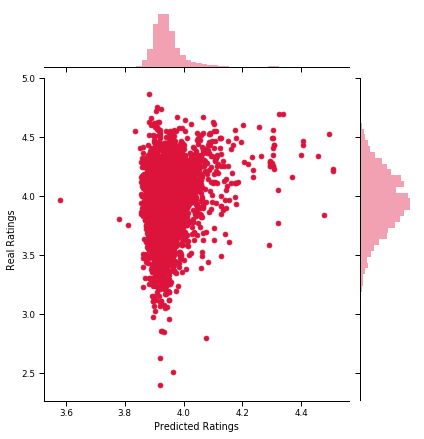

In [866]:
ratingsPred(ranked_df,responsecol)

## It seems that authors rank and book rank improved the prediction only slightly. Lets investigate why:

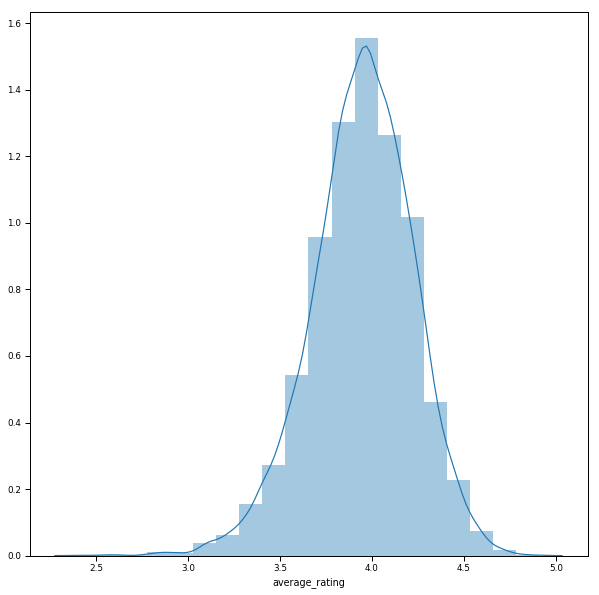

In [867]:
plt.figure(figsize=(10,10))
rating= ranked_df.average_rating.astype(float)
sns.distplot(rating, bins=20)

### As displayed on the above info graph, the bulk of the rating falls between 3.25 and 4.75 with the majority between the 3.5-4.5 mark.

<Figure size 1080x720 with 0 Axes>

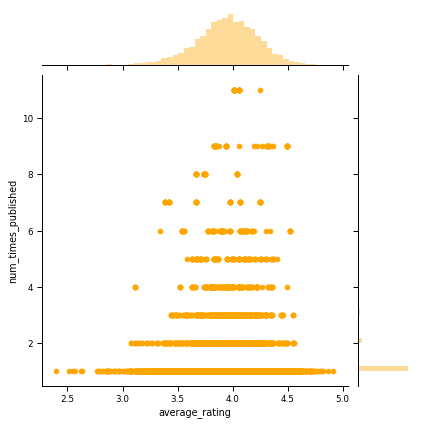

In [895]:
scatt_plot(ranked_df,'average_rating','num_times_published','orange')

### As per the above graph that displays the average rating across title rank. It seems that the books that have been published many times all fall within the normal range of 3.5-4.5. Hence how many times a book has been published still does not mean a higher than normal rating.

## With all relevant columns in place, I think its fair to now conclude that predicting the rating of a book based on the book's features is incoclusive. While the author's ranking, the number of pages and the ratings count as well as the text review count all play a factor in calculating an educated estimate of the rating, they are still not enough without the actual content of the book. Which is good news for book lovers :)

### So with the above colcuded we can now revise the initial hypothesis questions:

    * Does the reoccurance of a book through different publications bias the rating?
        * It does not as we investigated earlier, the results show that books that have been published many times dont necesarrily have higher than normal ratings (3.5-4.5 rating)
    * Does the ratings count and text review counts affect the rating
        * Yes, but to a small degree as it is clear that the books with higher than average ratings count and text review count still fall within the normal range 
    * Does the popularity of the author affect the rating?
        * No, as we concluded earlier that the authors with higher rankings do not fall outside the normal range of 3.5-4.5
    * Does the number of pages of a book contribute to the rating?
        * To a small extent, it was clear that the number of pages between 200-400 is preferable by readers as a alrge number of books in that page range fall within the 3.5-4.5 rating range
   
